# New York Air Quality Data Mining Project
Zeb Moffat  
Yida Fang

## Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
air_quality = pd.read_csv('./data/New_York_Air_Quality.csv')

# Remove completely blank Message column and rows with missing values.
air_quality.drop(columns=["Message"], inplace=True)
air_quality = air_quality.dropna()

# Exclude health outcomes (Asthma, Deaths) and traffic data (Vehicle miles) to focus on air pollutants.
valid_pollutants = [
    'Nitrogen dioxide (NO2)',
    'Fine particles (PM 2.5)',
    'Ozone (O3)',
    'Boiler Emissions- Total SO2 Emissions',
    'Boiler Emissions- Total NOx Emissions',
    'Boiler Emissions- Total PM2.5 Emissions',
    'Outdoor Air Toxics - Formaldehyde',
    'Outdoor Air Toxics - Benzene'
]

# Filter the dataset to only include these pollutants.
air_quality = air_quality[air_quality['Name'].isin(valid_pollutants)].copy()

# Convert Start_Date to datetime and extract Month/Year to form new columns
air_quality['Start_Date'] = pd.to_datetime(air_quality['Start_Date'])
air_quality['Year'] = air_quality['Start_Date'].dt.year
air_quality['Month'] = air_quality['Start_Date'].dt.month

# Calculate a Z-Score for each reading relative to its specific pollutant for fair comparisons.
# A high Z-score means that there is high polltion relative to its pollutant type.
air_quality['Scaled_Value'] = air_quality.groupby('Name')['Data Value'].transform(lambda x: (x - x.mean()) / x.std())

# Create a Binary Target for Classification (High Pollution).
# "High" = Top 20% (80th percentile) for that specific pollutant.
air_quality['Is_High_Pollution'] = air_quality.groupby('Name')['Data Value'].transform(lambda x: x > x.quantile(0.80)).astype(int)

## Association

### Method 1 (Rename)

### FP-Growth
What specific combinations of Location, Season, and Pollutant Type most frequently occur together with 'High Pollution' events?

In [39]:
# Restrict the dataset to only rows labeled as high pollution.
# This lets FP-Growth discover patterns specifically associated with dangerous or extreme air quality conditions.
high_pollution_df = air_quality[air_quality['Is_High_Pollution'] == 1].copy()

# Create a "Basket" of attributes for each row
# # Cast everything to string so they act as items
transactions = []
for _, row in high_pollution_df.iterrows():
    transaction = [
        str(row['Geo Type Name']),      # Geographic type (e.g., Borough)
        str(row['Geo Place Name']),     # Specific geographic location (e.g., Bronx)
        str(row['Name']),               # Pollutant being measured (e.g., Fine particles (PM 2.5))
        f"Month_{row['Month']}"         # Encoded month as item (e.g., Month_6)
    ]
    transactions.append(transaction)

# Encode Transactions 
# Example:
#   Bronx | PM2.5 | Brooklyn | Ozone
#     1        1       0        0
#     0        0       1        1
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Run FP-Growth
# min_support=0.05 means the rule must appear in at least 5% of high pollution events, filters niche events out
frequent_itemsets = fpgrowth(df_trans, min_support=0.05, use_colnames=True)

# Sset the metric to "lift" (strength of relation), and only keep rules with lift >= 1 (positive association).
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display Top Rules sorted by Confidence (Likelihood of consequence given antecedent)
print("Top Association Rules for High Pollution Events:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='confidence', ascending=False).head(10))

Top Association Rules for High Pollution Events:
                         antecedents               consequents   support  \
53                  (Ozone (O3), CD)                 (Month_6)  0.055340   
51                      (Ozone (O3))                 (Month_6)  0.136246   
26   (UHF34, Nitrogen dioxide (NO2))                (Month_12)  0.082524   
3           (Nitrogen dioxide (NO2))                (Month_12)  0.362136   
8       (Nitrogen dioxide (NO2), CD)                (Month_12)  0.159547   
37   (UHF42, Nitrogen dioxide (NO2))                (Month_12)  0.109709   
1                               (CD)                (Month_12)  0.266019   
17                           (UHF34)                (Month_12)  0.138511   
33  (UHF42, Fine particles (PM 2.5))                (Month_12)  0.077994   
7                     (Month_12, CD)  (Nitrogen dioxide (NO2))  0.159547   

    confidence      lift  
53    1.000000  3.044335  
51    1.000000  3.044335  
26    0.904255  1.476043  
3     

## Classification

### Method 1 (Rename)

### Random Forest
Can we predict if a location is currently experiencing 'High Pollution' based on the time of year, location, and the pollutant being measured?

Random Forest Accuracy: 0.7012903225806452

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.69      0.79      2476
           1       0.38      0.73      0.50       624

    accuracy                           0.70      3100
   macro avg       0.64      0.71      0.64      3100
weighted avg       0.80      0.70      0.73      3100



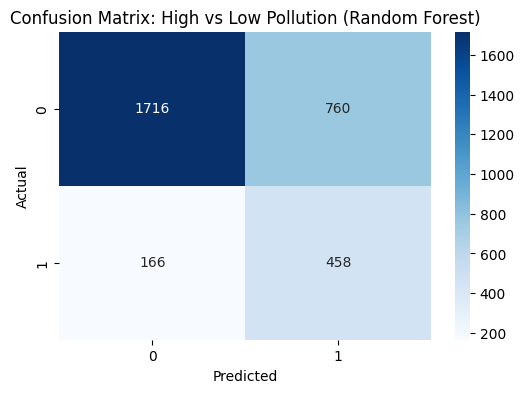

In [40]:
# Features and target
X = air_quality[['Indicator ID', 'Geo Join ID', 'Month']]
y = air_quality['Is_High_Pollution']

# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=8
)

# Preprocessing + Random Forest Pipeline
categorical_cols = ['Indicator ID', 'Geo Join ID', 'Month']

# Convert each categorical variable into a binary indicator so the model can use them.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# n_estimators = number of trees (300 gives stable performance)
# class_weight='balanced' helps the model handle the imbalanced dataset
# max_depth=None allows trees to grow fully unless tuning restricts them
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=8,
    class_weight='balanced'
)

# 1. Preprocess the data using the OneHotEncoder
# 2. Train the Random Forest on the transformed data
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf_model)
])

# Train the Model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: High vs Low Pollution (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Clustering

### Method 1 (Rename)

### K-Means
Can we identify distinct 'Pollution Profiles' for neighborhoods?

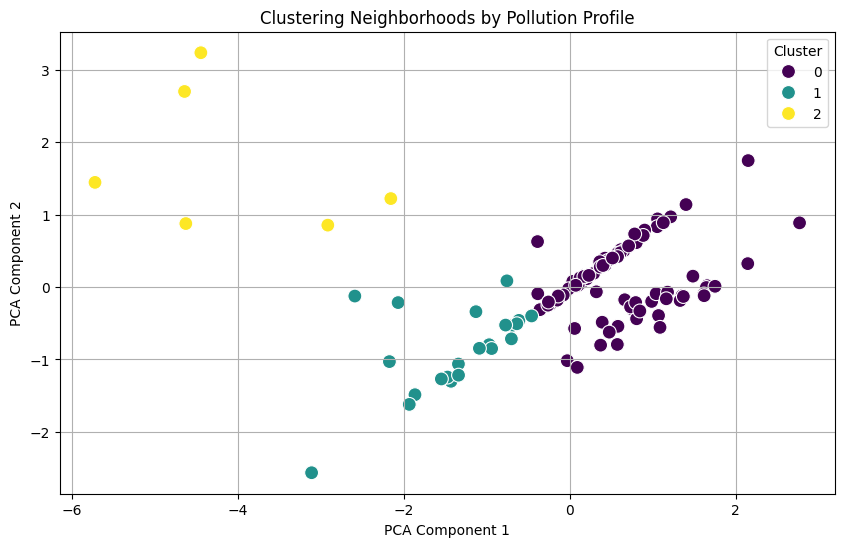


Full Cluster Profiles (All Pollutants):
Name     Boiler Emissions- Total NOx Emissions  \
Cluster                                          
0                                    -0.198584   
1                                     0.172481   
2                                     2.213942   

Name     Boiler Emissions- Total PM2.5 Emissions  \
Cluster                                            
0                                      -0.179531   
1                                       0.076898   
2                                       2.291318   

Name     Boiler Emissions- Total SO2 Emissions  Fine particles (PM 2.5)  \
Cluster                                                                   
0                                    -0.172737                -0.159546   
1                                     0.062877                 0.555617   
2                                     2.245354                 0.674775   

Name     Nitrogen dioxide (NO2)  Outdoor Air Toxics - Benzene  \
Cluste

In [5]:
# Pivot table: Rows = Locations, Columns = Pollutants, Values = Average Scaled Data Value
# Use the 'Scaled_Value' we created in preprocessing so units don't mess up distance metric.
pivot_df = air_quality.pivot_table(index='Geo Place Name', columns='Name', values='Scaled_Value', aggfunc='mean')

# Fill missing values with 0
pivot_df = pivot_df.fillna(0)

# Determine cluster count
kmeans = KMeans(n_clusters=3, random_state=8, n_init=10)
clusters = kmeans.fit_predict(pivot_df)

# Add cluster labels back to dataframe
pivot_df['Cluster'] = clusters

# Visualize with PCA (Reduce to 2 dimensions for plotting)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(pivot_df.drop('Cluster', axis=1))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=pivot_df['Cluster'], palette='viridis', s=100)
plt.title('Clustering Neighborhoods by Pollution Profile')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Compute cluster-level pollutant averages
cluster_means = pivot_df.groupby('Cluster').mean()

# Print full table of pollutant levels per cluster
print("\nFull Cluster Profiles (All Pollutants):")
print(cluster_means)

# Print top 5 defining pollutants per cluster
print("\nTop 5 Strongest Pollutants Defining Each Cluster:")
for c in cluster_means.index:
    top5 = cluster_means.loc[c].abs().sort_values(ascending=False).head(5)
    print(f"\nCluster {c} Top 5 Pollutants:")
    print(top5)
